--------------------------------------------------------------------------------
Travel time calculation using AnalyticalWell class, combined with 'omp removal'
--------------------------------------------------------------------------------

Example to calculate the travel time distribution per geological layer for a 
.. phreatic scheme, and to calculate the microbial organism removal. 
.. For an extensive description of the steps, see the basic example [AnalyticalWell & OMP removal](https://github.com/KWR-Water/sutra2/blob/main/research/Tutorial_AW_omp_removal.ipynb).

________________________________________

Import packages
-----------------

First we import the necessary python packages

In [14]:
import pandas as pd
from pathlib import Path
from set_cwd_to_project_root import project_root

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pandas import read_csv
from pandas import read_excel
import math
from scipy.special import kn as besselk
import sutra2.Analytical_Well as AW
import sutra2.ModPath_Well as mpw
import sutra2.Transport_Removal as TR

import warnings 
warnings.filterwarnings(action= 'ignore')

# # get directory of this file
# path = Path(__file__).parent
%load_ext autoreload
%autoreload 2

3.3.5
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Step 1: Define the HydroChemicalSchematisation
-----------------------------------------------
The first step is to define the hydrogeochemistry of the system using the HydroChemicalSchematisation class.

Lets start with a simple example defining a HydroChemicalSchematisation object for a phreatic aquifer:

In [15]:
phreatic_schematisation = AW.HydroChemicalSchematisation(schematisation_type='phreatic',
                                                        computation_method='analytical',
                                                        well_discharge=-7500, #m3/day
                                                        recharge_rate=0.0008, #m/day
                                                        thickness_vadose_zone_at_boundary=5, #m
                                                        thickness_shallow_aquifer=10,  #m
                                                        thickness_target_aquifer=40, #m
                                                        hor_permeability_target_aquifer=35, #m/day
                                                        redox_vadose_zone='anoxic',
                                                        redox_shallow_aquifer='anoxic',
                                                        redox_target_aquifer='deeply_anoxic',
                                                        pH_target_aquifer=7.,
                                                        temp_water=11.,
                                                        diffuse_input_concentration = 100, #ug/L
                                                        )


If not defined, default values are used for the rest of the parameters. To view all parameters in the schematisation:

In [16]:
phreatic_schematisation.__dict__

{'schematisation_type': 'phreatic',
 'computation_method': 'analytical',
 'removal_function': 'omp',
 'what_to_export': 'all',
 'well_name': 'well1',
 'temp_correction_Koc': True,
 'temp_correction_halflife': True,
 'biodegradation_sorbed_phase': True,
 'compute_thickness_vadose_zone': True,
 'ground_surface': 0.0,
 'thickness_vadose_zone_at_boundary': 5,
 'bottom_vadose_zone_at_boundary': -5.0,
 'thickness_shallow_aquifer': 10,
 'bottom_shallow_aquifer': -15.0,
 'thickness_target_aquifer': 40,
 'bottom_target_aquifer': -55.0,
 'thickness_full_capillary_fringe': 0.0,
 'porosity_vadose_zone': 0.35,
 'porosity_shallow_aquifer': 0.35,
 'porosity_target_aquifer': 0.35,
 'porosity_gravelpack': 0.35,
 'porosity_clayseal': 0.35,
 'moisture_content_vadose_zone': 0.2,
 'solid_density_vadose_zone': 2.65,
 'solid_density_shallow_aquifer': 2.65,
 'solid_density_target_aquifer': 2.65,
 'fraction_organic_carbon_vadose_zone': 0.001,
 'fraction_organic_carbon_shallow_aquifer': 0.0005,
 'fraction_organ

____________________________________


Step 2: Run the AnalyticalWell class
-------------------------------------
Next we create an AnalyticalWell object for the HydroChemicalSchematisation object we just made.

In [17]:
phreatic_well = AW.AnalyticalWell(phreatic_schematisation)

Then we calculate the travel time for each of the zones unsaturated, shallow aquifer and target aquifer zones
by running the .phreatic() function for the well object. 

In [18]:
phreatic_well.phreatic()

From the AnalyticalWell class two other important outputs are:

* df_particle - Pandas dataframe with data about the different flowlines per zone (unsaturated/shallow/target)
* df_flowline - Pandas dataframe with data about the flowlines per flowline (eg. total travel time per flowline)


In [19]:
print(phreatic_well.df_particle.head(4))

   flowline_id             zone  travel_time total_travel_time    xcoord  \
1            1          surface            0                 0  5.462742   
1            1      vadose_zone  2477.012721       2477.012721  5.462742   
1            1  shallow_aquifer  2227.727738       4704.740459  5.462742   
1            1   target_aquifer     0.175001        4704.91546  0.375000   

  ycoord  zcoord          redox  temp_water  travel_distance  porosity  \
1      1     0.0         anoxic        11.0         0.000000      0.35   
1      1    -5.0         anoxic        11.0        -9.908051      0.35   
1      1   -15.0         anoxic        11.0        24.908051      0.35   
1      1   -55.0  deeply_anoxic        11.0         5.462742      0.35   

   dissolved_organic_carbon   pH  fraction_organic_carbon  solid_density  
1                       0.0  7.0                   0.0010           2.65  
1                       0.0  7.0                   0.0010           2.65  
1                      


____________________________________


Step 3: Collect removal parameters for the mbo (MicrobialOrganism)
-------------------------------------------------------------------

You can retrieve the default removal parameters used to calculate the removal of microbial organisms [mbo] 
in the Transport class. The data are stored in a dictionary. In the example plant pathogen 'solani' is used.

In [20]:
test_organism = TR.MicrobialOrganism(organism_name='solani', organism_diam = 2.731e-9)
test_organism.organism_dict

{'organism_name': 'solani',
 'alpha0': {'suboxic': 0.037, 'anoxic': 0.00037, 'deeply_anoxic': 0.00037},
 'pH0': {'suboxic': 7.5, 'anoxic': 7.5, 'deeply_anoxic': 7.5},
 'organism_diam': 2.731e-09,
 'mu1': {'suboxic': 1.2472, 'anoxic': 0.1151, 'deeply_anoxic': 0.1151}}

To obtain a list of Organisms included in the MicrobialOrganism class, see organism_database.

In [21]:
for key, val in test_organism.micro_organism_database.items():
    print(key,"\n",val,"\n")

solani 
 {'organism_name': 'solani', 'alpha0': {'suboxic': 0.037, 'anoxic': 0.00037, 'deeply_anoxic': 0.00037}, 'pH0': {'suboxic': 7.5, 'anoxic': 7.5, 'deeply_anoxic': 7.5}, 'organism_diam': 2.731e-09, 'mu1': {'suboxic': 1.2472, 'anoxic': 0.1151, 'deeply_anoxic': 0.1151}} 

carotovorum 
 {'organism_name': 'carotovorum', 'alpha0': {'suboxic': 0.3, 'anoxic': 0.577, 'deeply_anoxic': 0.577}, 'pH0': {'suboxic': 7.5, 'anoxic': 7.5, 'deeply_anoxic': 7.5}, 'organism_diam': 1.803e-06, 'mu1': {'suboxic': 1.2664, 'anoxic': 0.1279, 'deeply_anoxic': 0.1279}} 

solanacearum 
 {'organism_name': 'solanacearum', 'alpha0': {'suboxic': 0.011, 'anoxic': 0.456, 'deeply_anoxic': 0.456}, 'pH0': {'suboxic': 7.5, 'anoxic': 7.5, 'deeply_anoxic': 7.5}, 'organism_diam': 1.945e-06, 'mu1': {'suboxic': 0.3519, 'anoxic': 0.1637, 'deeply_anoxic': 0.1637}} 



Optional: You may specify a different value for the organism removal parameters, for example
a different half-life for the anoxic redox zone. This can be input in the Transport class
and this will be used in the calculation for the removal of the mircoial organism. 

In [22]:
# Define removal parameters of pollutant
organism_solani_anox = TR.MicrobialOrganism(organism_name = 'solani',
                                    alpha0_suboxic=None,
                                    alpha0_anoxic=1.e-4,
                                    alpha0_deeply_anoxic=1.e-5,
                                    pH0_suboxic=None,
                                    pH0_anoxic=7.5,
                                    pH0_deeply_anoxic=7.5,
                                    mu1_suboxic=None,
                                    mu1_anoxic=0.0001,
                                    mu1_deeply_anoxic=0.00001,
                                    )

If you have specified values for the mbo (e.g. alpha0, pH0, mu1),
the default value is overwritten and used in the calculation of the removal. You can
view the updated organism removal parameters from the concentration object

In [23]:
organism_solani_anox.organism_dict

{'organism_name': 'solani',
 'alpha0': {'suboxic': 0.037, 'anoxic': 0.0001, 'deeply_anoxic': 1e-05},
 'pH0': {'suboxic': 7.5, 'anoxic': 7.5, 'deeply_anoxic': 7.5},
 'organism_diam': 2.731e-06,
 'mu1': {'suboxic': 1.2472, 'anoxic': 0.0001, 'deeply_anoxic': 1e-05}}

> Note: for organic micropollutants call the Substance class.
> See example for AnalyticalWell plus omp removal. e.g.:
> 
> test_substance = TR.Substance(substance_name='benzene')
> test_substance.substance_dict

____________________________________


Step 4: Run the Transport class
--------------------------------
To calculate the removal and the steady-state concentration in each zone, create a concentration
object by running the Transport class with the phreatic_well object and specifying
the microbial organism of interest.

In this example we use solani. First we create the object and view the substance properties:

In [24]:
# Call transport class
phreatic_transport = TR.Transport(well = phreatic_well, pollutant = organism_solani_anox)
# check removal parameters
phreatic_transport.removal_parameters


{'organism_name': 'solani',
 'alpha0': {'suboxic': 0.037, 'anoxic': 0.0001, 'deeply_anoxic': 1e-05},
 'pH0': {'suboxic': 7.5, 'anoxic': 7.5, 'deeply_anoxic': 7.5},
 'organism_diam': 2.731e-06,
 'mu1': {'suboxic': 1.2472, 'anoxic': 0.0001, 'deeply_anoxic': 1e-05}}

Then we can compute the removal by running the 'calc_advective_microbial_removal' function

In [25]:
# list endpoint ids
endpoint_ids = phreatic_transport.well.df_flowline.loc[:,"endpoint_id"].unique()
print(f"endpoint_id list: {endpoint_ids}")

# keep track of final cocnentration per endpoint_id
C_final = {}
# Update df_flowline and df_particle. Calculate final concentration at endpoint_id(s)
for endpoint_id in endpoint_ids:
    df_particle, df_flowline, C_final[endpoint_id] = phreatic_transport.calc_advective_microbial_removal(endpoint_id = endpoint_id,
                                                conc_start = 1., conc_gw = 0.)
    print(f"Final concentration {endpoint_id}: {C_final[endpoint_id]}")
    print(df_particle.columns)


endpoint_id list: ['well1']
Final concentration well1: 9.586708716027099e-60
Index(['flowline_id', 'zone', 'travel_time', 'total_travel_time', 'xcoord',
       'ycoord', 'zcoord', 'redox', 'temp_water', 'travel_distance',
       'porosity', 'dissolved_organic_carbon', 'pH', 'fraction_organic_carbon',
       'solid_density', 'mu1', 'alpha0', 'pH0', 'relative_distance',
       'porewater_velocity', 'rho_water', 'grainsize', 'alpha', 'k_att',
       'lamda', 'concentration_in_well', 'steady_state_concentration',
       'retardation', 'breakthrough_travel_time'],
      dtype='object')


In [26]:
phreatic_well.df_particle.head(4)

,flowline_id,zone,travel_time,total_travel_time,xcoord,ycoord,zcoord,redox,temp_water,travel_distance,porosity,dissolved_organic_carbon,pH,fraction_organic_carbon,solid_density,mu1,alpha0,pH0,relative_distance,porewater_velocity
1,1,surface,0,0,5.462742,1,0.0,anoxic,11.0,0.000000,0.35,0.0,7.0,0.0010,2.65,0.00010,0.00010,7.5,None,None
1,1,vadose_zone,2477.012721,2477.012721,5.462742,1,-5.0,anoxic,11.0,-9.908051,0.35,0.0,7.0,0.0010,2.65,0.00010,0.00010,7.5,None,None
1,1,shallow_aquifer,2227.727738,4704.740459,5.462742,1,-15.0,anoxic,11.0,24.908051,0.35,0.0,7.0,0.0005,2.65,0.00010,0.00010,7.5,None,None
1,1,target_aquifer,0.175001,4704.91546,0.375000,1,-55.0,deeply_anoxic,11.0,5.462742,0.35,0.0,7.0,0.0005,2.65,0.00001,0.00001,7.5,None,None


Once the removal has been calculated, you can view the steady-state concentration
and breakthrough time per zone for the mbo in the df_particle:

In [27]:
df_particle.loc[:,['zone', 'steady_state_concentration', 'travel_time']]

,zone,steady_state_concentration,travel_time
1,surface,1.0,0
1,vadose_zone,0.0,2477.012721
1,shallow_aquifer,0.0,2227.727738
1,target_aquifer,0.0,0.175001
2,surface,1.0,0
...,...,...,...
104,target_aquifer,0.0,92720.553915
105,surface,1.0,0
105,vadose_zone,0.0,1250.010658
105,shallow_aquifer,0.0,4374.981348


View the steady-state concentration of the flowline or the steady-state
contribution of the flowline to the concentration in the well

In [28]:
df_flowline.loc[:,['breakthrough_concentration', 'breakthrough_travel_time']].head(5)


,breakthrough_concentration,breakthrough_travel_time
1,8.933832e-55,4704.91546
2,6.851050e-57,4890.542455
3,3.917594e-59,5090.353031
4,2.474657e-61,5289.21052
5,6.678984e-63,5432.777061


Plot the breakthrough curve at the well over time:

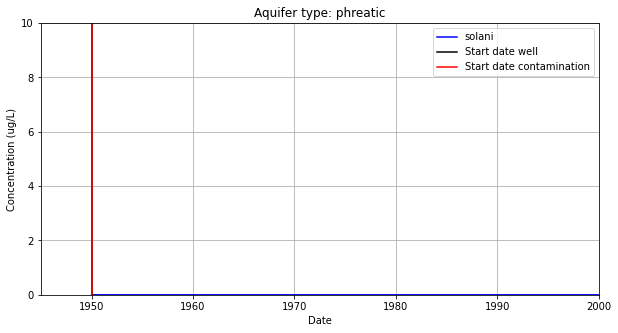

In [29]:
solani_plot = phreatic_transport.plot_concentration(ylim=[0,10 ])

You can also compute the removal for a different mbo of interest (plant pathogens):

* carotovorum
* solanacearum

Or optionally a different species of own choice (non-default):
* MS2 (virus)

To do so you can use the original schematisation, but specify a different mbo when you create the Transport object.

In [30]:
# phreatic_well = AW.AnalyticalWell(phreatic_schematisation)
phreatic_well.phreatic() 
# removal parameters carotovorum (default)
organism_carotovorum = TR.MicrobialOrganism(organism_name = "carotovorum")
print(organism_carotovorum.organism_dict)

# Transport object
phreatic_transport = TR.Transport(phreatic_well, pollutant = organism_carotovorum)
# keep track of final cocnentration per endpoint_id
C_final = {}
# Update df_flowline and df_particle. Calculate final concentration at endpoint_id(s)
for endpoint_id in endpoint_ids:
    df_particle, df_flowline, C_final[endpoint_id] = phreatic_transport.calc_advective_microbial_removal( 
                                                endpoint_id = endpoint_id,
                                                conc_start = 1., conc_gw = 0.)
    print(f"Final concentration {endpoint_id}: {C_final[endpoint_id]}")


{'organism_name': 'carotovorum', 'alpha0': {'suboxic': 0.3, 'anoxic': 0.577, 'deeply_anoxic': 0.577}, 'pH0': {'suboxic': 7.5, 'anoxic': 7.5, 'deeply_anoxic': 7.5}, 'organism_diam': 1.803e-06, 'mu1': {'suboxic': 1.2664, 'anoxic': 0.1279, 'deeply_anoxic': 0.1279}}
Final concentration well1: 0.0


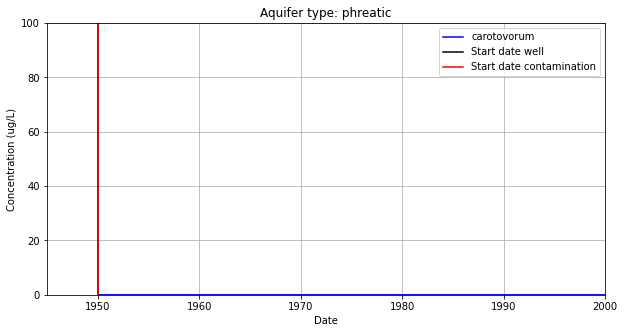

In [31]:

# Plot the breakthrough concentration
carotovorum_plot = phreatic_transport.plot_concentration(ylim=[0,100 ])


In [38]:
# phreatic_well = AW.AnalyticalWell(phreatic_schematisation)
phreatic_well.phreatic() 
# removal parameters carotovorum (default)
organism_solanacearum = TR.MicrobialOrganism(organism_name = "solanacearum")
print(organism_solanacearum.organism_dict)

# Transport object
phreatic_transport = TR.Transport(phreatic_well, pollutant = organism_solanacearum)
# keep track of final cocnentration per endpoint_id
C_final = {}
# Update df_flowline and df_particle. Calculate final concentration at endpoint_id(s)
for endpoint_id in endpoint_ids:
    df_particle, df_flowline, C_final[endpoint_id] = phreatic_transport.calc_advective_microbial_removal( 
                                                endpoint_id = endpoint_id,
                                                conc_start = 1., conc_gw = 0.)
    print(f"Final concentration {endpoint_id}: {C_final[endpoint_id]}")


{'organism_name': 'solanacearum', 'alpha0': {'suboxic': 0.011, 'anoxic': 0.456, 'deeply_anoxic': 0.456}, 'pH0': {'suboxic': 7.5, 'anoxic': 7.5, 'deeply_anoxic': 7.5}, 'organism_diam': 1.945e-06, 'mu1': {'suboxic': 0.3519, 'anoxic': 0.1637, 'deeply_anoxic': 0.1637}}
Final concentration well1: 0.0


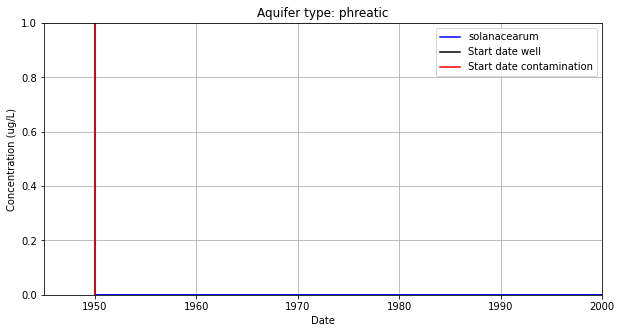

In [44]:

solanacearum_plot = phreatic_transport.plot_concentration(ylim=[0,1])


Define removal parameters for a virus (MS2): manual input

In [45]:
# phreatic_well = AW.AnalyticalWell(phreatic_schematisation)
phreatic_well.phreatic() 

# microbial removal properties of microbial organism
organism_name = 'MS2'
# reference_collision_efficiency [-]
alpha0 = {"suboxic": 1.e-3, "anoxic": 1.e-5, "deeply_anoxic": 1.e-5}
# reference pH for calculating collision efficiency [-]
pH0 = {"suboxic": 6.6, "anoxic": 6.8, "deeply_anoxic": 6.8}
# diameter of pathogen/species [m]
organism_diam =  2.33e-8
# inactivation coefficient [1/day]
mu1 = {"suboxic": 0.149,"anoxic": 0.023,"deeply_anoxic": 0.023}
# removal parameters for MS2 (manual input MicrobialOrganism)
organism_MS2 = TR.MicrobialOrganism(organism_name = organism_name,
                                    alpha0_suboxic = alpha0["suboxic"],
                                    alpha0_anoxic = alpha0["anoxic"],
                                    alpha0_deeply_anoxic = alpha0["deeply_anoxic"],
                                    pH0_suboxic = pH0["suboxic"],
                                    pH0_anoxic = pH0["anoxic"],
                                    pH0_deeply_anoxic = pH0["deeply_anoxic"],
                                    mu1_suboxic = mu1["suboxic"],
                                    mu1_anoxic = mu1["anoxic"],
                                    mu1_deeply_anoxic = mu1["deeply_anoxic"],
                                    organism_diam = organism_diam)





Call the transport object and calculate the mbo removal

In [46]:

# Transport object
phreatic_transport = TR.Transport(phreatic_well, pollutant = organism_MS2)
print(organism_MS2.organism_dict)

# keep track of final cocnentration per endpoint_id
C_final = {}
# Update df_flowline and df_particle. Calculate final concentration at endpoint_id(s)
for endpoint_id in endpoint_ids:
    df_particle, df_flowline, C_final[endpoint_id] = phreatic_transport.calc_advective_microbial_removal( 
                                                endpoint_id = endpoint_id,
                                                conc_start = 1., conc_gw = 0.)
    print(f"Final concentration {endpoint_id}: {C_final[endpoint_id]}")


{'organism_name': 'MS2', 'alpha0': {'suboxic': 0.001, 'anoxic': 1e-05, 'deeply_anoxic': 1e-05}, 'pH0': {'suboxic': 6.6, 'anoxic': 6.8, 'deeply_anoxic': 6.8}, 'organism_diam': 2.33e-08, 'mu1': {'suboxic': 0.149, 'anoxic': 0.023, 'deeply_anoxic': 0.023}}
Final concentration well1: 8.671197644712766e-61


Plot the breakthrough concentration

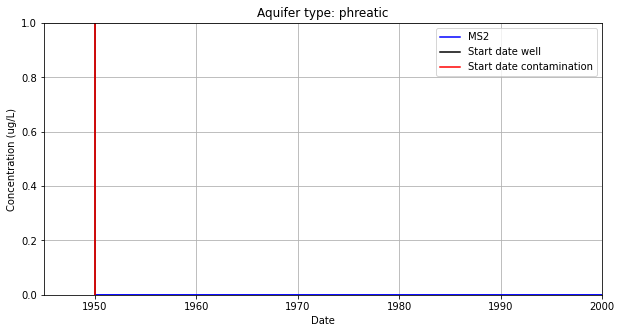

In [47]:

MS2_plot = phreatic_transport.plot_concentration( ylim=[0,1])


The total travel time can be plotted as a function of radial distance from the well, or as a function
of the cumulative fraction of abstracted water: 

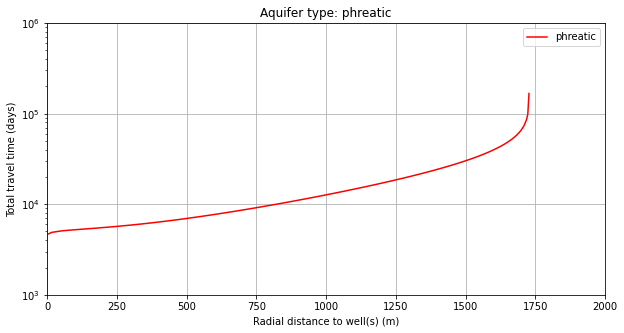

In [48]:
radial_plot = phreatic_well.plot_travel_time_versus_radial_distance(xlim=[0, 2000], ylim=[1e3, 1e6])


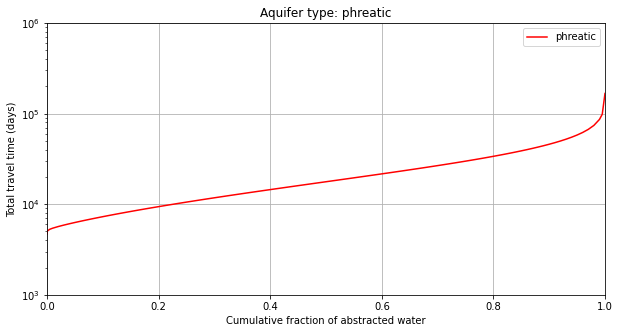

In [49]:
cumulative_plot = phreatic_well.plot_travel_time_versus_cumulative_abstracted_water(xlim=[0, 1], ylim=[1e3, 1e6])